#### Code Description

#### 1. Required Packages
##### Below are the packages used in the model development

In [1]:
import skill_metrics as sm
import pandas as pd ; pd.set_option('display.max_columns', 500) # dataframes
import numpy as np # mathsy bits
import ipywidgets as widgets # widgets

from sklearn.model_selection import train_test_split #split data into train and test sets

# feature selection + gridsearch
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import cross_val_score

# models
from sklearn.linear_model import Lars, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score # model evaluation
from sklearn.pipeline import Pipeline # pipeline

import joblib # saving models
from datetime import datetime # get time for labelling saved models

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

import mpld3 # hover-over labels for plots
mpld3.disable_notebook()



#### 2. Loading the dataset

In [2]:
dataset=pd.read_excel("20240325_HLC_DataSet_Descriptors_Curation_Final.xlsx")
dataset.fillna(0,inplace=True)
dataset.head(5)
dataset.shape

(1089, 1443)

#### 3.Data Preparation 
##### 3.1 Replacing Nan with zereos

In [3]:
dataset.fillna(0,inplace=True)
dataset.shape

(1089, 1443)

##### 3.2 Finding null values in dataset

In [4]:
dataset.isnull().sum()

NAME       0
HLC        0
Log_HLC    0
MW         0
AMW        0
          ..
PDI        0
BLTF96     0
BLTD48     0
BLTA96     0
SAscore    0
Length: 1443, dtype: int64

#### 3.3 Separating data into features (X) and target variable (Y)

In [5]:
x=dataset.drop(["HLC","Log_HLC","NAME"],axis=1)
x.head()
x.shape

(1089, 1440)

#### 3.4 Feature Scaling (Feature Normalization)

In [6]:
# Initialize the QuantileTransformer
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer()
# Fit and transform the features
X_scaled = scaler.fit_transform(x)
# Convert back to DataFrame to keep column structure
X_scaled_df = pd.DataFrame(X_scaled, columns=x.columns)

In [7]:
y=dataset["Log_HLC"]
y.head()
y.shape

(1089,)

#### 3.5 Data Splitting into train, test and validation set

In [8]:
# First split: 70% train, 30% temp (which will be divided into validation and test)
x_train, x_temp, y_train, y_temp = train_test_split(X_scaled_df, y, test_size=0.3, random_state=42)

# Second split: 50% validation, 50% test of the temp dataset (which is 15% of the original each)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

#### 3.6 Cleaning x_train, x_test and x_validation column names

In [9]:
# Renaming the columns to remove special characters
x_train = x_train.copy()
x_test = x_test.copy()
x_val = x_val.copy()

# Replace special characters in column names
special_chars = ['[', ']', '<']
for char in special_chars:
    x_train.columns = [col.replace(char, '') for col in x_train.columns]
    x_test.columns = [col.replace(char, '') for col in x_test.columns]

#### 3.7 Dropping Duplicate columns 

In [10]:
def get_duplicate_columns(dataset):
    duplicate_columns={}
    seen_columns={} ## The columns that has been seen and keep track of columns seen so far
    
    for column in dataset.columns:
        current_column=dataset[column]
        
        ## Hashable the data in the columns int bytes
        try:
            current_column_hash=current_column.values.tobytes() ## If conversion is succesful store the hash value
        except AttributeError: ##If there is an attribute error it means that the column value is not integer or float rather it is string, so convert it into string and encode it into bytes
            current_column_hash=current_column.values.tostring().encode()
        if current_column_hash in seen_columns:
            if seen_columns[current_column_hash] in duplicate_columns:
                duplicate_columns[seen_columns[current_column_hash]].append(column)
            else:
                duplicate_columns[seen_columns[current_column_hash]]=[column]
        else:
            seen_columns[current_column_hash] = column
    return duplicate_columns

In [11]:
duplicate_columns = get_duplicate_columns(x_train)

In [12]:
duplicate_columns # DUplicate columns in the dataset

{'MWC01': ['MPC01'],
 'nBO': ['SpPos_L'],
 'VE1_L': ['VE1sign_L'],
 'VE2_L': ['VE2sign_L'],
 'VE3_L': ['VE3sign_L'],
 'P_VSA_m_1': ['P_VSA_v_1'],
 'Chi0_EA': ['Chi0_AEA(ed)', 'Chi0_AEA(bo)', 'Chi0_AEA(dm)', 'Chi0_AEA(ri)'],
 'Chi1_EA': ['Chi1_AEA(ed)', 'Chi1_AEA(bo)', 'Chi1_AEA(dm)', 'Chi1_AEA(ri)'],
 'SpMax_EA': ['SM09_AEA(bo)', 'Eig01_EA'],
 'SpMax_EA(ed)': ['SM10_AEA(dm)', 'Eig01_EA(ed)'],
 'SpMax_EA(bo)': ['SM11_AEA(ri)', 'Eig01_EA(bo)'],
 'SM10_AEA(bo)': ['Eig02_EA'],
 'SM11_AEA(bo)': ['Eig03_EA'],
 'SM12_AEA(bo)': ['Eig04_EA'],
 'SM13_AEA(bo)': ['Eig05_EA'],
 'SM14_AEA(bo)': ['Eig06_EA'],
 'SM15_AEA(bo)': ['Eig07_EA'],
 'SM11_AEA(dm)': ['Eig02_EA(ed)'],
 'SM12_AEA(dm)': ['Eig03_EA(ed)'],
 'SM13_AEA(dm)': ['Eig04_EA(ed)'],
 'SM14_AEA(dm)': ['Eig05_EA(ed)'],
 'SM15_AEA(dm)': ['Eig06_EA(ed)'],
 'SM02_AEA(ri)': ['Eig07_EA(ed)'],
 'SM12_AEA(ri)': ['Eig02_EA(bo)'],
 'SM13_AEA(ri)': ['Eig03_EA(bo)'],
 'SM14_AEA(ri)': ['Eig04_EA(bo)'],
 'SM15_AEA(ri)': ['Eig05_EA(bo)'],
 'SpMax_EA(ri)': 

In [13]:
for one_list in duplicate_columns.values():
    x_train.drop(columns=one_list,inplace=True)
    x_test.drop(columns=one_list,inplace=True)
    x_val.drop(columns=one_list,inplace=True)

In [14]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(762, 1398)
(164, 1398)
(163, 1398)


#### 3.8 Dropping columns with constant and quasi constant values using variance thershold

In [15]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.05)
sel.fit(x_train)


VarianceThreshold(threshold=0.05)

In [16]:
sum(sel.get_support())
columns=x_train.columns[sel.get_support()]
columns

Index(['MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me', 'Mp', 'Mi',
       ...
       'ESOL', 'SAtot', 'Vx', 'VvdwMG', 'VvdwZAZ', 'PDI', 'BLTF96', 'BLTD48',
       'BLTA96', 'SAscore'],
      dtype='object', length=1394)

#### 3.9 Converting into pandas dataframe

In [17]:
x_train = sel.transform(x_train)
x_test = sel.transform(x_test)
x_val=sel.transform(x_val)

x_train = pd.DataFrame(x_train, columns=columns)
x_test = pd.DataFrame(x_test, columns=columns)
x_val=pd.DataFrame(x_val,columns=columns)


In [18]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(762, 1394)
(164, 1394)
(163, 1394)


#### 3.10 Correlation matrix

<Axes: >

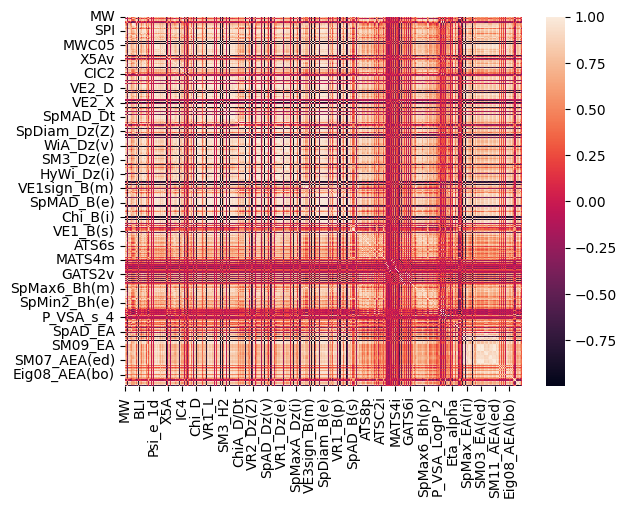

In [19]:
import seaborn as sns
sns.heatmap(x_train.corr()) # Visualing correlation matrix of training dataset

In [20]:
corr_matrix=x_train.corr()
#corr_matrix.to_csv("20240404_Correlation matrix.csv")

#### 3.11 Column dropping based on correlation matrix, this suggests that many columns have similar values and we can drop simialr values column for efficient processing.

In [21]:
# Get the column names of the DataFrame
columns = corr_matrix.columns

# Create an empty list to keep track of columns to drop
columns_to_drop = []

# Loop over the columns
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        # Access the cell of the DataFrame
        if corr_matrix.loc[columns[i], columns[j]] > 0.95:
            columns_to_drop.append(columns[j])

print(len(columns_to_drop))

56317


In [22]:
## Converting the columns to set to remove the duplicate columns
columns_to_drop = set(columns_to_drop)
len(columns_to_drop)

984

#### 3.12 Dropping columnds with high correlation

In [23]:
columns_to_drop = set(columns_to_drop)
x_train.drop(columns=columns_to_drop,axis=1, inplace=True)
x_test.drop(columns=columns_to_drop,axis=1, inplace=True)
x_val.drop(columns=columns_to_drop,axis=1, inplace=True)

In [24]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(762, 410)
(164, 410)
(163, 410)


In [25]:
print(x_train.columns) # Print the column names in the data
x_train.head(5)

Index(['MW', 'AMW', 'Sv', 'Se', 'Mv', 'Me', 'Mp', 'Mi', 'GD', 'nTA',
       ...
       'Q2', 'RPCG', 'RNCG', 'SPP', 'LDI', 'Hy', 'MLOGP', 'ESOL', 'PDI',
       'SAscore'],
      dtype='object', length=410)


,MW,AMW,Sv,Se,Mv,Me,Mp,Mi,GD,nTA,RBF,nH,H%,C%,nCsp3,nCsp2,Fsp3,ZM1V,ZM1Kup,ON1V,Qindex,DBI,HNar,Xt,Ram,BLI,SPI,PJI2,DECC,S2K,S3K,PHI,PW2,PW3,MAXDN,MAXDP,DELS,Psi_i_A,Psi_i_t,Psi_i_0d,Psi_i_1d,Psi_e_1,BAC,LOC,MPC07,MPC08,PCD,X0A,X1A,X2A,X3A,X4A,X5A,X0v,X2v,X0Av,X2Av,X3Av,X4Av,X5Av,IAC,AAC,IDDE,IVDE,rGes,Vindex,Yindex,IC1,IC2,IC3,TIC1,TIC2,SIC0,SIC1,SIC2,SIC3,SIC4,CIC0,CIC1,CIC2,CIC3,CIC4,CIC5,SpPosA_A,VE2_A,VE1sign_A,VE3sign_A,Chi_D,J_D,VE1_D,VE2_D,VE1sign_D,VE3sign_D,VR2_D,TI1_L,TI2_L,STN_L,SpMax_L,AVS_X,ChiA_X,SpPosA_X,SpMax_X,SpDiam_X,SM5_X,VE1sign_X,VE3sign_X,Chi_Dt,J_Dt,VE1sign_Dt,VE3sign_Dt,WiA_D/Dt,Chi_D/Dt,ChiA_D/Dt,SpPosA_D/Dt,Chi_Dz(Z),J_Dz(Z),SM1_Dz(Z),VE2_Dz(Z),VE1sign_Dz(Z),VE3sign_Dz(Z),WiA_Dz(v),Chi_Dz(v),J_Dz(v),SM1_Dz(v),VE1sign_Dz(v),VE3sign_Dz(v),J_Dz(e),SM1_Dz(e),VE1sign_Dz(e),H_Dz(p),Chi_Dz(p),J_Dz(p),VE1sign_Dz(p),VE3sign_Dz(p),SM1_Dz(i),AVS_B(m),ChiA_B(m),SpMax_B(m),SpDiam_B(m),SpMAD_B(m),VE1sign_B(m),VE3sign_B(m),AVS_B(v),ChiA_B(v),SpPosA_B(v),SpMAD_B(v),VE1sign_B(v),VE2sign_B(v),AVS_B(e),ChiA_B(e),SpPosA_B(e),VE1sign_B(e),VE2sign_B(e),SpPosA_B(p),WiA_B(s),AVS_B(s),ChiA_B(s),SpMax_B(s),SpDiam_B(s),SpMAD_B(s),VE1sign_B(s),VE3sign_B(s),ATS4m,ATS6m,ATS7m,ATS8m,ATS2s,ATS3s,ATS4s,ATS5s,ATSC1m,ATSC2m,ATSC3m,ATSC4m,ATSC5m,ATSC3v,ATSC5v,ATSC1e,ATSC2e,ATSC3e,ATSC4e,ATSC5e,ATSC1p,ATSC2p,ATSC3p,ATSC4p,ATSC1i,ATSC3i,ATSC5i,ATSC1s,ATSC2s,ATSC3s,ATSC4s,MATS1m,MATS2m,MATS3m,MATS4m,MATS5m,MATS6m,MATS7m,MATS8m,MATS1v,MATS2v,MATS3v,MATS4v,MATS5v,MATS6v,MATS7v,MATS8v,MATS1e,MATS2e,MATS3e,MATS4e,MATS5e,MATS6e,MATS7e,MATS8e,MATS1p,MATS2p,MATS3p,MATS4p,MATS5p,MATS6p,MATS7p,MATS8p,MATS1i,MATS2i,MATS3i,MATS4i,MATS5i,MATS6i,MATS7i,MATS8i,MATS1s,MATS2s,MATS3s,MATS4s,MATS5s,MATS6s,MATS7s,MATS8s,GATS1m,GATS2m,GATS3m,GATS4m,GATS5m,GATS6m,GATS7m,GATS8m,GATS1v,GATS2v,GATS3v,GATS4v,GATS5v,GATS6v,GATS1e,GATS2e,GATS3e,GATS4e,GATS5e,GATS1p,GATS2p,GATS3p,GATS4p,GATS1i,GATS2i,GATS3i,GATS4i,GATS5i,GATS1s,GATS2s,GATS3s,GATS4s,GGI1,GGI2,GGI3,JGI1,JGI2,JGI3,JGI4,JGI5,JGT,SpMax2_Bh(m),SpMax3_Bh(m),SpMax1_Bh(v),SpMax3_Bh(v),SpMax3_Bh(e),SpMax2_Bh(s),SpMax3_Bh(s),SpMax4_Bh(s),SpMin1_Bh(m),SpMin2_Bh(m),SpMin3_Bh(m),SpMin4_Bh(m),SpMin5_Bh(m),SpMin1_Bh(v),SpMin2_Bh(v),SpMin1_Bh(e),SpMin5_Bh(e),SpMin1_Bh(s),SpMin3_Bh(s),SpMin4_Bh(s),SpMin5_Bh(s),P_VSA_LogP_1,P_VSA_LogP_2,P_VSA_LogP_3,P_VSA_LogP_4,P_VSA_LogP_5,P_VSA_LogP_7,P_VSA_LogP_8,P_VSA_MR_1,P_VSA_MR_2,P_VSA_MR_3,P_VSA_MR_5,P_VSA_MR_6,P_VSA_MR_7,P_VSA_m_2,P_VSA_m_3,P_VSA_m_4,P_VSA_m_5,P_VSA_v_2,P_VSA_v_3,P_VSA_e_2,P_VSA_e_3,P_VSA_e_4,P_VSA_e_5,P_VSA_e_6,P_VSA_p_1,P_VSA_p_2,P_VSA_i_1,P_VSA_i_2,P_VSA_i_3,P_VSA_i_4,P_VSA_s_3,P_VSA_s_4,P_VSA_s_5,P_VSA_s_6,P_VSA_ppp_L,P_VSA_ppp_D,P_VSA_ppp_ar,P_VSA_ppp_con,P_VSA_ppp_ter,P_VSA_charge_1,P_VSA_charge_2,P_VSA_charge_3,P_VSA_charge_6,P_VSA_charge_7,P_VSA_charge_8,P_VSA_charge_9,Eta_alpha_A,Eta_betaS_A,Eta_betaP_A,Eta_C,Eta_C_A,Eta_L_A,Eta_F,Eta_F_A,Eta_FL_A,Eta_B_A,Eta_sh_p,Eta_sh_y,Eta_sh_x,Eta_epsi_2,Eta_epsi_5,Eta_D_epsiB,Eta_D_epsiC,Eta_psi1,Eta_D_beta,SpMaxA_EA(ed),SpMaxA_EA(bo),SpMax_EA(ri),SpMaxA_EA(ri),SpMAD_EA(ri),SpMax_AEA(dm),SpMaxA_AEA(dm),SpDiam_AEA(dm),SpMAD_AEA(dm),Chi0_EA(dm),Chi1_EA(dm),SM12_AEA(bo),SM13_AEA(bo),SM14_AEA(bo),SM15_AEA(bo),Eig08_EA(ed),Eig05_AEA(bo),Eig06_AEA(bo),Eig07_AEA(bo),Eig08_AEA(bo),Eig02_AEA(dm),Eig04_AEA(dm),Eig05_AEA(dm),Eig06_AEA(dm),Eig07_AEA(dm),Eig06_AEA(ri),Eig07_AEA(ri),qpmax,qnmax,Qpos,Qneg,Qmean,Q2,RPCG,RNCG,SPP,LDI,Hy,MLOGP,ESOL,PDI,SAscore
0,0.178178,0.273273,0.246747,0.289289,0.156156,0.066567,0.450450,0.507508,0.849349,0.474474,0.610110,0.685185,0.939940,0.211211,0.694194,0.000000,1.000000,0.062563,0.040873,0.409910,0.224725,0.506006,0.150651,0.885886,0.279780,0.944819,0.232232,0.183684,0.203704,0.315284,0.770771,0.477707,0.316316,0.156156,0.158074,0.173653,0.129278,0.161286,0.931381,0.098352,0.905897,0.165219,0.450951,0.480480,0.000000,0.000000,0.000000,0.857858,0.828829,0.862863,0.949449,0.000000,0.000000,0.289774,0.374974,0.938502,0.935258,0.982069,0.000000,0.000000,0.220721,0.196697,0.349850,0.47847

### 4. Model Selection (Selection of the best model)
##### 4.1 Training on all features (410) to get Taylor diagram for model comparison

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63083
[LightGBM] [Info] Number of data points in the train set: 609, number of used features: 410
[LightGBM] [Info] Start training from score 0.849157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

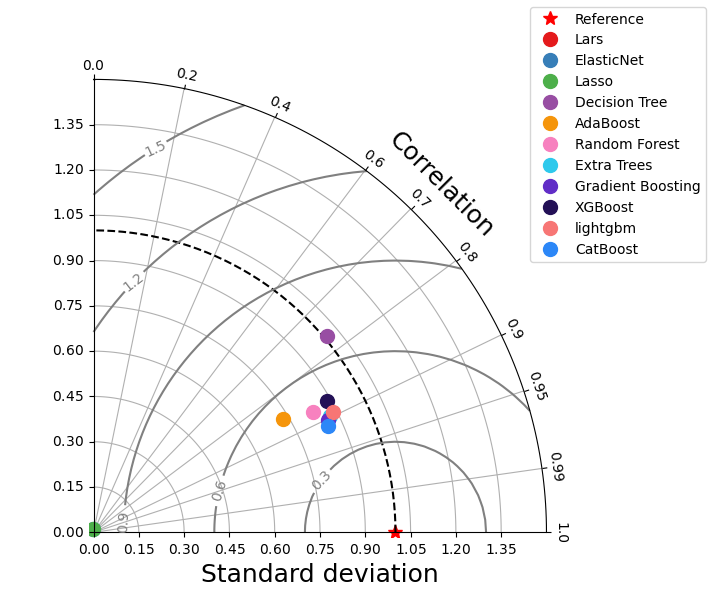

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


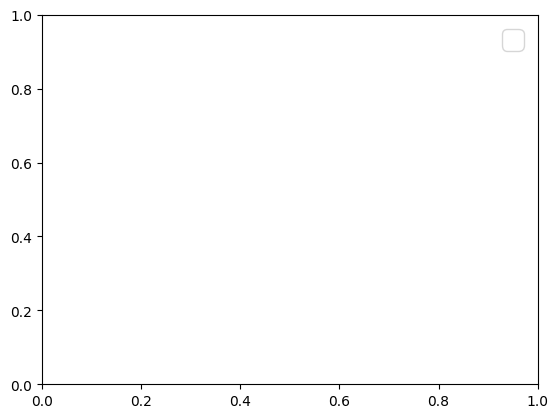

In [26]:
from easy_mpl import taylor_plot
from easy_mpl.utils import version_info
from sklearn.model_selection import cross_val_predict
# Define your models
models = {
    "Lars": Lars(),
    "ElasticNet": ElasticNet(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Extra Trees": ExtraTreesRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "lightgbm": LGBMRegressor(),
    "CatBoost": CatBoostRegressor(verbose=False),
}

# Assuming x_train, y_train, x_test, and y_test are already defined
# Prepare a DataFrame to store your results
results_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE'])

# Normalize the standard deviation of model predictions to make the reference (observed) standard deviation equal to 1
stddev_obs = np.std(y_train)  # Standard deviation of observations
normalized_taylor_stats = {}

for model_name, model in models.items():
    # Fit the model and make predictions
    predictions = cross_val_predict(model, x_train, y_train, cv=5)
    
    # Compute normalized statistics
    stddev = np.std(predictions) / stddev_obs  # Normalize by observed standard deviation
    corrcoef = np.corrcoef(y_train, predictions)[0, 1]
    
    # Store the normalized statistics for easy_mpl taylor_plot
    normalized_taylor_stats[model_name] = {
        'std': stddev,  # Normalized standard deviation
        'corr_coeff': corrcoef,
        # 'pbias': pbias (optional and needs to be calculated if you want to include it)
    }

# The observations have a 'std' of 1 because we're normalizing by stddev_obs
observations_normalized = {'std': 1}

# Create the Taylor Diagram with normalized stats
_ = taylor_plot(observations_normalized, normalized_taylor_stats)

# Customize legend size
plt.legend(fontsize='20')

# Show the plot
plt.show()



##### Taylor diagram shows that 4 models are showing good normalized RMSE values, so in order to get the best model, we have decided to choose another model selection method.

#### 4.2 Model Selection based on validation dataset

In [27]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Ignore data conversion warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)


results_df = pd.DataFrame(columns=["Model", "R2 train", "RMSE train", "MSE train", "R2 test", "RMSE test", "MSE test"])

iteration = 0

for name, model in models.items():
    
    iteration += 1
    print("Iteration no.", ":", iteration)
    
    model.fit(x_train, y_train) # Model training
    
    # Compute  Training metrics 
    train_pred = model.predict(x_train)
    r2_train = r2_score(y_train, train_pred)
    mse_train = mean_squared_error(y_train, train_pred)
    rmse_train = np.sqrt(mse_train)
    
    # Compute  Testing metrics 
    test_pred = model.predict(x_val)
    r2_test = r2_score(y_val, test_pred)
    mse_test = mean_squared_error(y_val, test_pred)
    rmse_test = np.sqrt(mse_test)
    
   # Create a temporary DataFrame with the results
    temp_df = pd.DataFrame({
        'Model': [name],
        'R2 train': [r2_train],
        'RMSE train': [rmse_train],
        'MSE train': [mse_train],
        'R2 test': [r2_test],
        'RMSE test': [rmse_test],
        'MSE test': [mse_test]
    })
    
    # Append the temporary DataFrame to the results DataFrame
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Sorting the results by R2 score on the test set
results_df = results_df.sort_values(by='R2 test', ascending=False)

# Display the results DataFrame
print(results_df)

results_df

Iteration no. : 1
Iteration no. : 2
Iteration no. : 3
Iteration no. : 4
Iteration no. : 5
Iteration no. : 6
Iteration no. : 7
Iteration no. : 8
Iteration no. : 9
Iteration no. : 10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80129
[LightGBM] [Info] Number of data points in the train set: 762, number of used features: 410
[LightGBM] [Info] Start training from score 0.843251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

,Model,R2 train,RMSE train,MSE train,R2 test,RMSE test,MSE test
10,CatBoost,0.996910,0.106380,0.011317,8.279299e-01,0.839390,7.045757e-01
6,Extra Trees,0.999268,0.051768,0.002680,8.198463e-01,0.858881,7.376758e-01
7,Gradient Boosting,0.964345,0.361386,0.130600,8.134250e-01,0.874053,7.639690e-01
9,lightgbm,0.995358,0.130397,0.017003,7.966857e-01,0.912421,8.325113e-01
8,XGBoost,0.999263,0.051962,0.002700,7.889188e-01,0.929685,8.643145e-01
5,Random Forest,0.968007,0.342323,0.117185,7.853313e-01,0.937552,8.790045e-01
4,AdaBoost,0.832546,0.783173,0.613360,7.139221e-01,1.082314,1.171404e+00
3,Decision Tree,0.999268,0.051768,0.002680,5.562738e-01,1.347934,1.816926e+00
1,ElasticNet,0.000000,1.913859,3.662858,-1.368478e-03,2.024921,4.100305e+00
2,Lasso,0.000000,1.913859,3.662858,-1.368478e-03,2.024921,4.100305e+00


In [ ]:
# Saving results in CSV file
# results_df.to_csv("20240404_Model Development Results_All features_Cross validation_on x_validation data_V1.csv")

### 5. Optimization of the best model from the above table

#### 5.1 Optuna with cross validation to avoid overfitting

In [28]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 5, 200),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 100),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 100),
        "max_depth": trial.suggest_int("max_depth", 2, 50), 
    }
    
    model = GradientBoostingRegressor(**params, random_state=42)
    # Use cross-validation to evaluate the model
    # Adjust cv (number of folds) based on your dataset size
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    # Return the average RMSE across all folds
    return np.mean(-scores)


In [29]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 100)

[I 2024-05-26 16:42:13,492] A new study created in memory with name: no-name-2bb63825-3697-428d-8e85-423c418d1ede
[I 2024-05-26 16:42:43,715] Trial 0 finished with value: 1.330333292565983 and parameters: {'learning_rate': 0.007843159179244838, 'n_estimators': 129, 'min_samples_split': 35, 'min_samples_leaf': 87, 'max_depth': 45}. Best is trial 0 with value: 1.330333292565983.
[I 2024-05-26 16:43:34,567] Trial 1 finished with value: 0.8441611697742196 and parameters: {'learning_rate': 0.0607623091672994, 'n_estimators': 190, 'min_samples_split': 99, 'min_samples_leaf': 90, 'max_depth': 45}. Best is trial 1 with value: 0.8441611697742196.
[I 2024-05-26 16:44:15,309] Trial 2 finished with value: 0.8469653795641946 and parameters: {'learning_rate': 0.4792502746078222, 'n_estimators': 168, 'min_samples_split': 79, 'min_samples_leaf': 99, 'max_depth': 48}. Best is trial 1 with value: 0.8441611697742196.
[I 2024-05-26 16:44:52,409] Trial 3 finished with value: 1.2565796573134411 and paramete

##### 5.2 Visualizing best model parameters

In [30]:
best_params = study.best_params

print("Best parametrs", best_params)

Best parametrs {'learning_rate': 0.15017676967616203, 'n_estimators': 192, 'min_samples_split': 13, 'min_samples_leaf': 79, 'max_depth': 7}


In [31]:
best_objective = study.best_value

print("Best objective value", ":", best_objective)

Best objective value : 0.7910371232277941


In [32]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate

In [33]:
plot_optimization_history(study)

In [34]:
plot_param_importances(study)

In [35]:
plot_parallel_coordinate(study)

#### 5.3 Model training based on best hyperparametrs

In [36]:
final_model = GradientBoostingRegressor(**best_params,random_state=42)

final_model.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.15017676967616203, max_depth=7,
                          min_samples_leaf=79, min_samples_split=13,
                          n_estimators=192, random_state=42)

#### 5.4 Evaluation metrics (RMSE and R2 score)

In [37]:
from sklearn.metrics import mean_squared_error, r2_score

# Existing code to predict and calculate RMSE
predictions = final_model.predict(x_val)
rmse = np.sqrt(mean_squared_error(y_val, predictions))

# Added line of code to calculate R2 score
r2 = r2_score(y_val, predictions)

print(f'Validation RMSE: {rmse}')
print(f'Validation R2: {r2}')

Validation RMSE: 0.875881999819937
Validation R2: 0.8126434245105445


#### 5.5 Model evlauation on vaidation dataset

In [38]:
# Evaluate the model on the separate validation set
predictions = final_model.predict(x_val)
rmse = np.sqrt(mean_squared_error(y_val, predictions))

print(f'Validation RMSE: {rmse}')

Validation RMSE: 0.875881999819937


In [39]:
# Evaluate the model on the separate validation set
predictions_test = final_model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions_test))

print(f'Test RMSE: {rmse}')

Test RMSE: 0.8617677094940512


#### 5.6 Results visualization

(array([-4., -2.,  0.,  2.,  4.,  6.]),
 [Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6')])

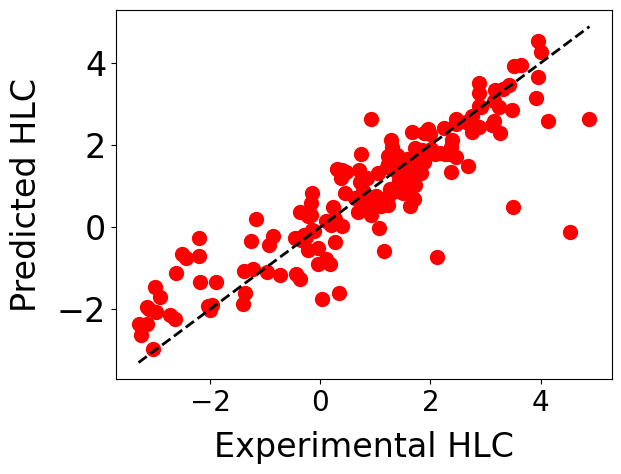

In [40]:
plt.scatter(y_test, predictions_test, alpha=1, color="red", label='Testing',s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
#plt.title('Test Set: Actual vs. Predicted',fontsize = 24, pad=10)
plt.xlabel('Experimental HLC', fontsize=24, labelpad=10)
plt.ylabel('Predicted HLC', fontsize=24, labelpad=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=24)

#### 6. Model interpretation (To explain the targte varibale and input feature relationship)
##### 6.1 SHAP for feature interpretation

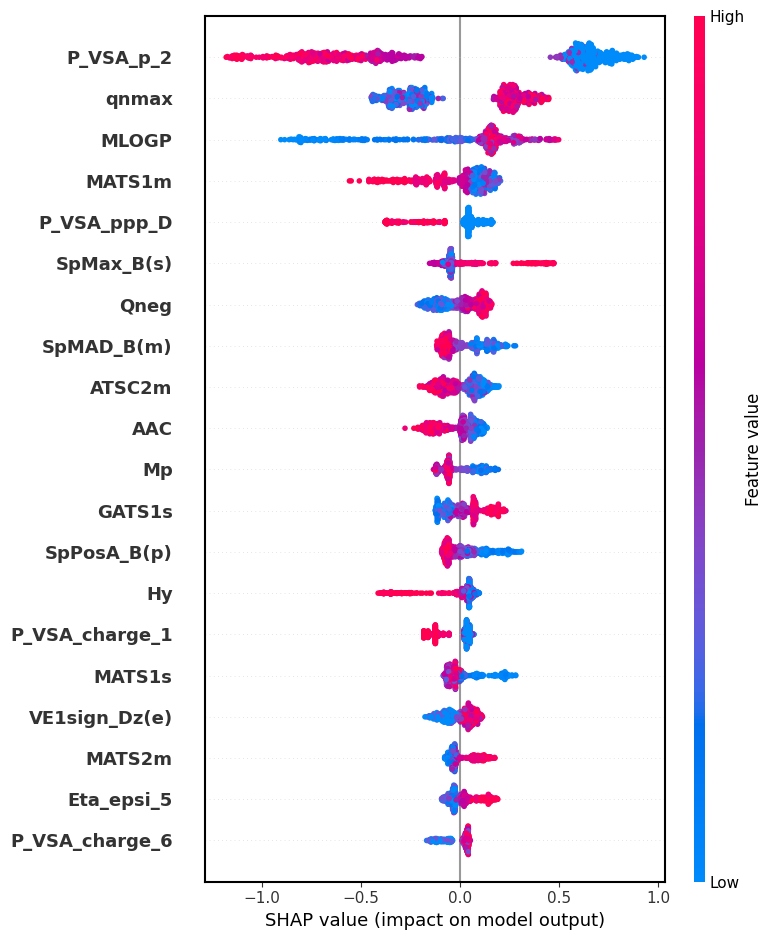

In [41]:
import matplotlib.pyplot as plt
import shap

# Initialize the SHAP explainer with your model
explainer = shap.Explainer(final_model)

# Compute SHAP values for the training set
shap_values = explainer(x_train)

# Plot with a higher-resolution output
plt.figure(figsize=(16, 8))

# Generate the SHAP summary plot
shap.summary_plot(shap_values, x_train, show=False)

# Get the current figure and axes
fig = plt.gcf()
ax = plt.gca()

# Modify the axes properties
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.5)

# Set the y-axis label to bold
ax.set_ylabel(ax.get_ylabel(), fontsize=18, weight='bold')

# Attempt to set the y-tick labels to bold
for label in ax.get_yticklabels():
    label.set_weight('bold')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("shap_catboost_bold.png", dpi=600, bbox_inches='tight')
plt.show()

#### 7. Model Re-Training on selected features from all the feature selection methods (Filter and Wrapper method)
##### We applied different different feature selection method and based on the domain knowledge and results from the feature selection methods, below mentioned features are selected for model training and we term it as best subset of features.

In [42]:

features = [
    "P_VSA_charge_1","MLOGP", "P_VSA_e_5", "P_VSA_ppp_D", "Q2", "SpMax_B(s)", "Hy","SpMAD_B(m)",
    "GATS1e","ATSC2m", "P_VSA_i_2","Mp","SPP","Qneg", "AVS_B(v)", "TI1_L"
]

# Filter the x_train, x_test, and x_val datasets
X_train_filtered = x_train[features]
X_test_filtered = x_test[features]
X_val_filtered = x_val[features]



#### Model based on the best subset of features and again optimizing the model hyperparameters

In [43]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
    }
    
    model = GradientBoostingRegressor(**params, random_state=42)
    # Use cross-validation to evaluate the model
    # Adjust cv (number of folds) based on your dataset size
    scores = cross_val_score(model, X_train_filtered, y_train, cv=5, scoring='neg_root_mean_squared_error')
    # Return the average RMSE across all folds
    return np.mean(-scores)

In [44]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 100)

[I 2024-05-26 19:10:45,509] A new study created in memory with name: no-name-d86d4b96-28a6-41a6-bc39-6f01b220e960
[I 2024-05-26 19:10:45,993] Trial 0 finished with value: 1.313841298734979 and parameters: {'learning_rate': 0.04210200567176767, 'n_estimators': 15, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_depth': 6}. Best is trial 0 with value: 1.313841298734979.
[I 2024-05-26 19:10:46,494] Trial 1 finished with value: 1.8600457596200144 and parameters: {'learning_rate': 0.0021731340114462833, 'n_estimators': 19, 'min_samples_split': 4, 'min_samples_leaf': 16, 'max_depth': 7}. Best is trial 0 with value: 1.313841298734979.
[I 2024-05-26 19:10:46,848] Trial 2 finished with value: 1.890930661627835 and parameters: {'learning_rate': 0.0013059453003070435, 'n_estimators': 14, 'min_samples_split': 13, 'min_samples_leaf': 16, 'max_depth': 5}. Best is trial 0 with value: 1.313841298734979.
[I 2024-05-26 19:10:47,275] Trial 3 finished with value: 1.2723806794813783 and parameters: {'

In [45]:
best_params = study.best_params

print("Best parametrs", best_params)

Best parametrs {'learning_rate': 0.21218600776267868, 'n_estimators': 20, 'min_samples_split': 20, 'min_samples_leaf': 18, 'max_depth': 7}


In [46]:
final_model_new = GradientBoostingRegressor(**best_params,random_state=42)

final_model_new.fit(X_train_filtered, y_train)

GradientBoostingRegressor(learning_rate=0.21218600776267868, max_depth=7,
                          min_samples_leaf=18, min_samples_split=20,
                          n_estimators=20, random_state=42)

#### Model Prediction on validation data

In [47]:
train_pred = final_model_new.predict(X_train_filtered)
#test_pred = model.predict(X_test)
val_pred = final_model_new.predict(X_val_filtered)

# Resutls
print("Train MSE", ":", mean_squared_error(y_train, train_pred))
print("Train RMSE", ":", np.sqrt(mean_squared_error(y_train, train_pred)))
print("Train R2", ":", r2_score(y_train, train_pred))
print("")
print("==========Validation==============")
print("")
print("Val MSE", ":", mean_squared_error(y_val, val_pred))
print("Val RMSE", ":", np.sqrt(mean_squared_error(y_val, val_pred)))
print("Val R2", ":", r2_score(y_val, val_pred))


Train MSE : 0.2097663413814558
Train RMSE : 0.45800255608615964
Train R2 : 0.9427315109559932

==========Validation==============

Val MSE : 0.9170582504310928
Val RMSE : 0.9576315838729906
Val R2 : 0.7760378337089953


#### Model evaluation on test data

In [48]:
# Evaluate the model on the separate validation set
predictions_test = final_model_new.predict(X_test_filtered)
rmse = np.sqrt(mean_squared_error(y_test, predictions_test))

print(f'Test RMSE: {rmse}')
print("Test R2", ":", r2_score(y_test, predictions_test))

Test RMSE: 0.9533459811643898
Test R2 : 0.7369852174973963


(array([-4., -2.,  0.,  2.,  4.,  6.]),
 [Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6')])

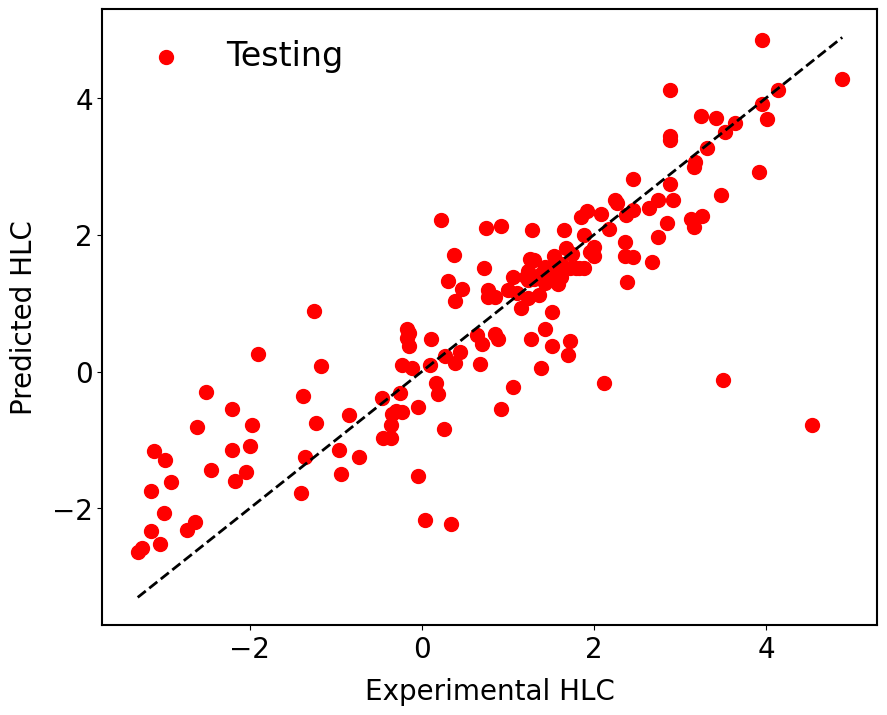

In [49]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, predictions_test, alpha=1, color="red", label='Testing',s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
#plt.title('Test Set: Actual vs. Predicted',fontsize = 24, pad=10)
plt.xlabel('Experimental HLC', fontsize=20, labelpad=10)
plt.ylabel('Predicted HLC', fontsize=20, labelpad=10)
plt.legend(fontsize=24,frameon=False)
ax=plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#### Training and Prediction plots

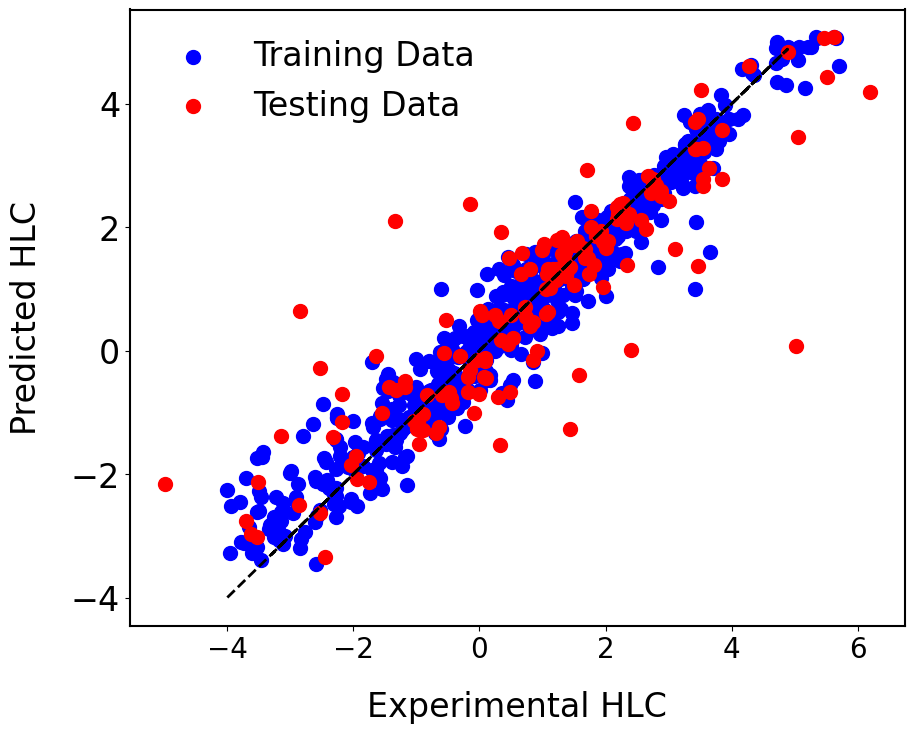

In [50]:
import matplotlib.pyplot as plt

# Predictions on the training set
train_predictions = final_model_new.predict(X_train_filtered)
val_predictions = final_model_new.predict(X_val_filtered)

# Creating a single graph for both training and testing datasets
plt.figure(figsize=(10, 8))

# Plotting for the training set
plt.scatter(y_train, train_predictions, alpha=1, color="blue", label='Training Data',s=100)

# Plotting for the test set
plt.scatter(y_val, val_predictions, alpha=1, color="red", label='Testing Data',s=100)

# Ideal prediction line
plt.plot([y_train.min(), y_test.max(), y_test.min(), y_test.max()], 
         [y_train.min(), y_test.max(), y_test.min(), y_test.max()], 'k--', lw=2)

#plt.title('Actual vs. Predicted Values', fontsize=24, pad = 10)
plt.xlabel('Experimental HLC', fontsize=24, labelpad=20)
plt.ylabel('Predicted HLC', fontsize=24, labelpad=20)
# Customize tick params for both axes
plt.xticks(fontsize=20)
plt.yticks(fontsize=24)
ax=plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

# Save the plot of the top 25 features as a PNG file
plt.savefig("CatBoost_Final Model.png", dpi=600, bbox_inches='tight')
plt.legend(fontsize=24,frameon=False)

plt.show()

### SHAPly values for the final model interpretation

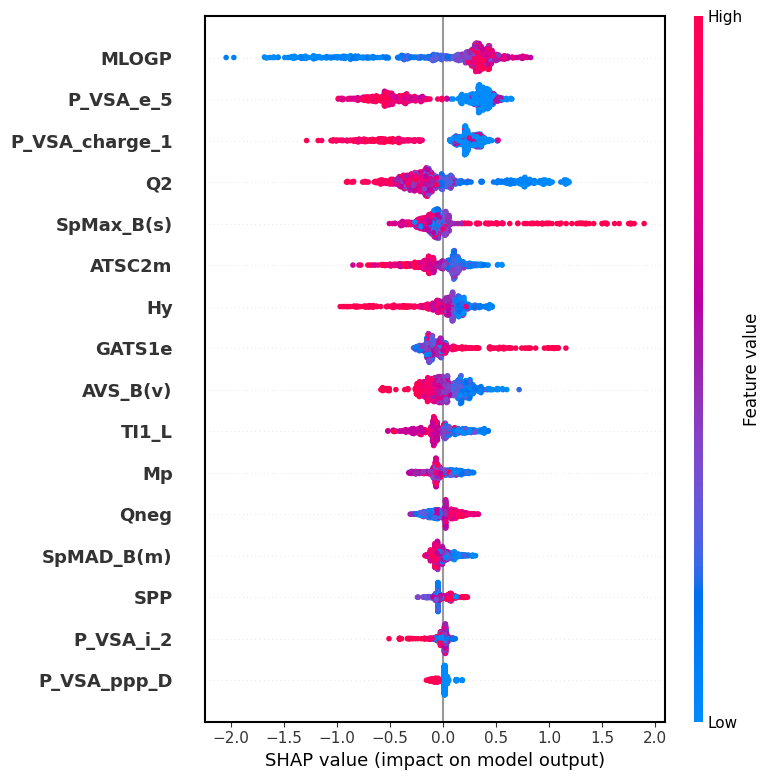

In [51]:
import matplotlib.pyplot as plt
import shap

# Initialize the SHAP explainer with your model
explainer = shap.Explainer(final_model_new)

# Compute SHAP values for the training set
shap_values = explainer(X_train_filtered)

# Plot with a higher-resolution output
plt.figure(figsize=(16, 8))

# Generate the SHAP summary plot
shap.summary_plot(shap_values, X_train_filtered, show=False)

# Get the current figure and axes
fig = plt.gcf()
ax = plt.gca()

# Modify the axes properties
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.5)

# Set the y-axis label to bold
ax.set_ylabel(ax.get_ylabel(), fontsize=18, weight='bold')

# Attempt to set the y-tick labels to bold
for label in ax.get_yticklabels():
    label.set_weight('bold')

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig("shap_catboost_bold.png", dpi=600, bbox_inches='tight')
plt.show()

In [52]:
# Calculate the mean SHAP values for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Print the mean SHAP values
for name, value in zip(X_train_filtered.columns, mean_shap_values):
    print(f"{name}: {value:.4f}")

P_VSA_charge_1: 0.3484
MLOGP: 0.4466
P_VSA_e_5: 0.4294
P_VSA_ppp_D: 0.0362
Q2: 0.3313
SpMax_B(s): 0.1954
Hy: 0.1632
SpMAD_B(m): 0.0664
GATS1e: 0.1459
ATSC2m: 0.1676
P_VSA_i_2: 0.0410
Mp: 0.0975
SPP: 0.0631
Qneg: 0.0972
AVS_B(v): 0.1453
TI1_L: 0.1353


#### Feature SHAP values

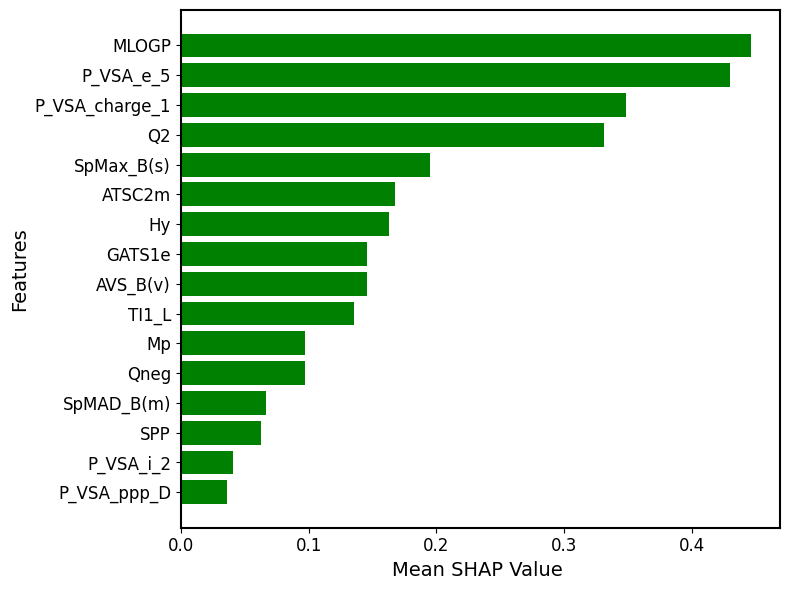

In [53]:
# Calculate SHAP Values
shap_values = explainer(X_train_filtered)

# Calculate the mean absolute SHAP values for each feature
mean_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create a bar chart with the specified styles
plt.figure(figsize=(8, 6))
# Sort the features by mean absolute SHAP values
sorted_indices = np.argsort(mean_shap_values)
sorted_features = X_train_filtered.columns[sorted_indices]
sorted_shap_values = mean_shap_values[sorted_indices]

bars = plt.barh(sorted_features, sorted_shap_values, color='green')

# Set title and labels with specified font sizes
# plt.title('Mean Absolute SHAP Values', fontsize=20)
plt.xlabel('Mean SHAP Value ', fontsize=14)
plt.ylabel('Features', fontsize=14)

# Set tick parameters for axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['left'].set_color('black')
ax=plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.5)

plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

#### SHAP dependence plots

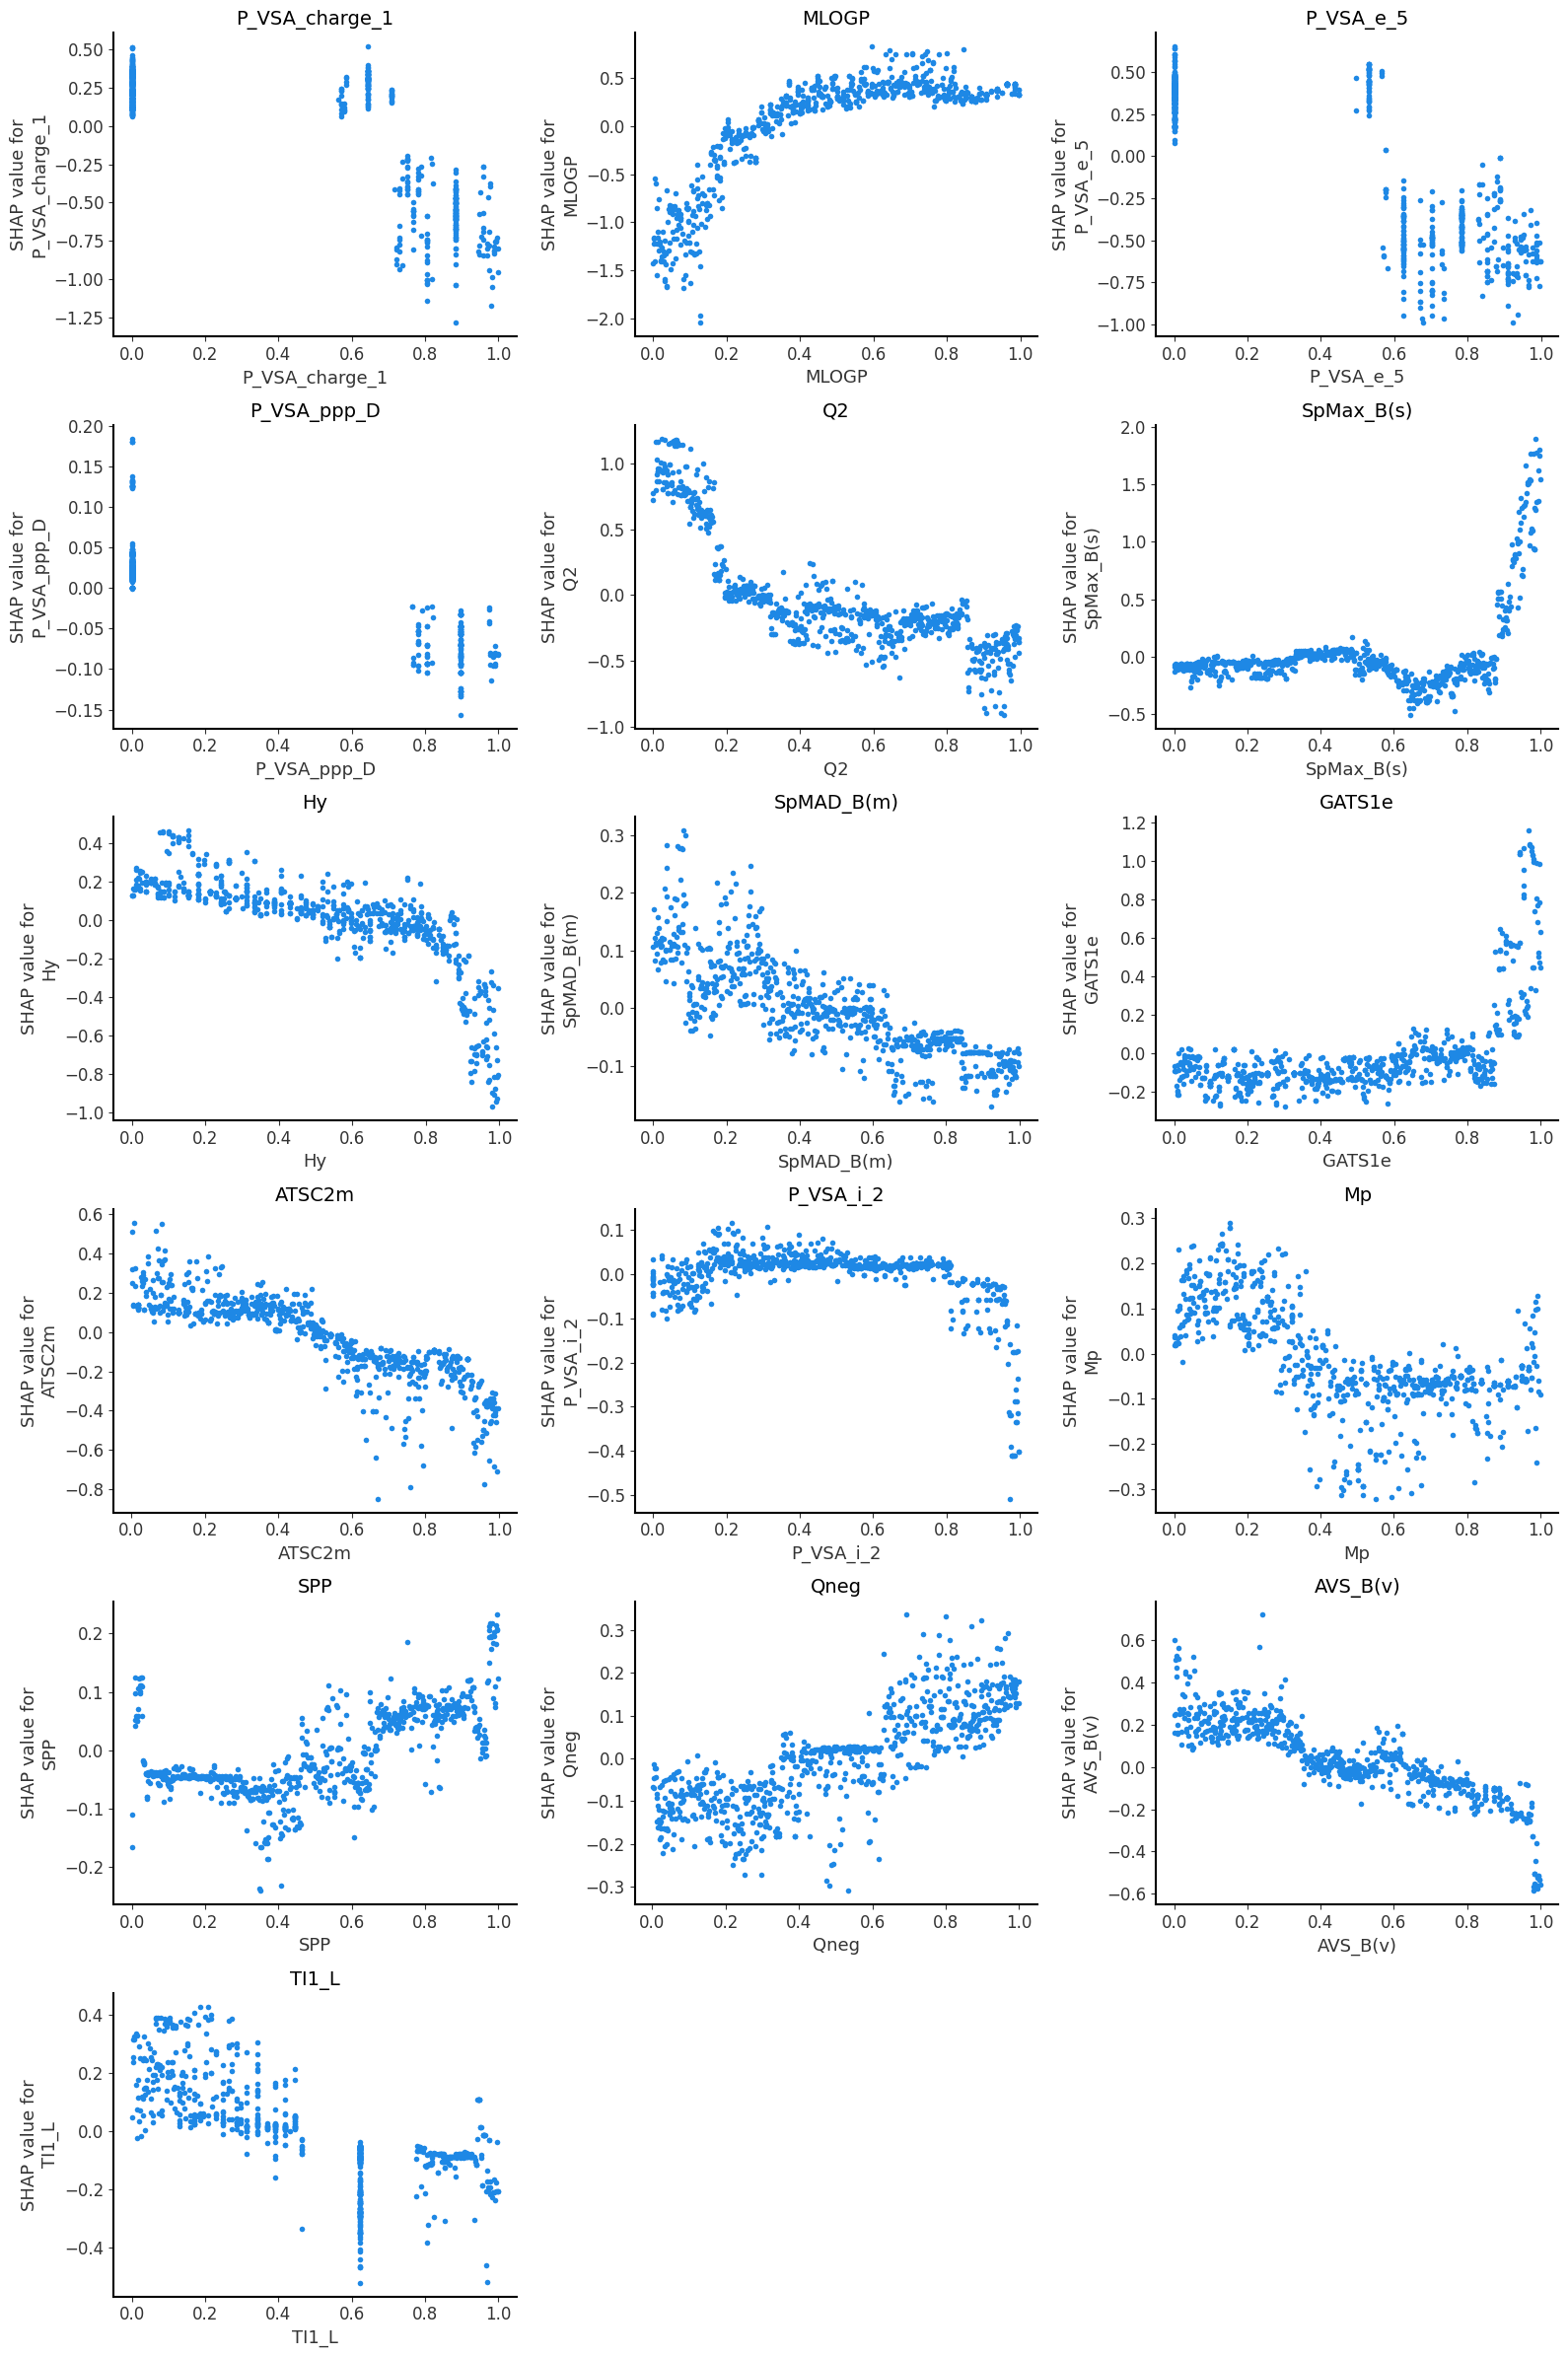

In [54]:
import matplotlib.pyplot as plt

# Determine the number of rows needed for subplots (3 plots per row)
num_features = len(X_train_filtered.columns)
num_rows = num_features // 3 + (1 if num_features % 3 else 0)

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(16, 4 * num_rows))  # Adjust the figure size as needed

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, feature in enumerate(X_train_filtered.columns):
    # Generate SHAP Dependence Plot for the current feature in its respective subplot
    shap.dependence_plot(feature, shap_values.values, X_train_filtered, display_features=X_train_filtered,
                         interaction_index=None, ax=axes[i], show=False)
    
    # Customizing plot appearance according to your specifications
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    for spine in axes[i].spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1.5)
    axes[i].spines['top'].set_color('none')
    axes[i].spines['right'].set_color('none')
    axes[i].spines['bottom'].set_linewidth(1.5)
    axes[i].spines['bottom'].set_color('black')
    axes[i].spines['left'].set_linewidth(1.5)
    axes[i].spines['left'].set_color('black')
    
    # Set title for each subplot
    axes[i].set_title(f'{feature}', fontsize=14)

# Hide any unused axes if the number of features is not a multiple of 3
for j in range(i + 1, num_rows * 3):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust the layout to ensure everything fits without overlapping
plt.show()


### Saving the model

In [55]:
joblib.dump(final_model_new, 'Final_model_Gradient Boosting_new.joblib')

print("Model saved successfully.")

Model saved successfully.
